# Exercise 4 - cGAN: Conditional GAN (4p)

The goal of this exercise is get familiar with another type of GAN the cGAN and specifically a Least Squares Deep Convolutional one similar to Exercise 3. The original cGAN model was proposed by [Mirza, Osindero, 2014](https://arxiv.org/pdf/1411.1784).

Conditional GANs are a form of supervised learning as opposed to the original GAN.

In [209]:
skip_training = True  # Set this flag to True before validation and submission

In [160]:
# During evaluation, this cell sets skip_training to True
# skip_training = True

import tools, warnings
warnings.showwarning = tools.customwarn

In [161]:
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

import torch
import torchvision
import torch.nn as nn
from torch.nn import functional as F
from torchvision import transforms

import tools
import tests

In [162]:
# When running on your own computer, you can specify the data directory by:
# data_dir = tools.select_data_dir('/your/local/data/directory')
data_dir = tools.select_data_dir()

The data directory is /coursedata


In [163]:
#device = torch.device('cuda:0')
device = torch.device('cpu')

In [164]:
if skip_training:
    # The models are always evaluated on CPU
    device = torch.device("cpu")

# Data

We will use MNIST data in this exercise. **Note that we re-scale images so that the pixel intensities are in the range [-1, 1].**

In [165]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Transform to tensor
    transforms.Normalize((0.5,), (0.5,))  # Scale images to [-1, 1]
])

trainset = torchvision.datasets.MNIST(root=data_dir, train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root=data_dir, train=False, download=True, transform=transform)

batch_size = 100
dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

# Generative adversarial networks

Our task is to train a generative model of the data, that is a model from which we can draw samples that will have a distribution similar to the distribution of the training data (MNIST digits in our case).

## Generator

The generative model that we are going to train is:
\begin{align}
z &\sim N(0, I)
\\
x &= g(z)
\end{align}
that is the data is generated by applying a nonlinear transformation to samples drawn from the standard normal distribution.

We are going to model $g$ with a deep neural network created below. In DCGAN, the generator processes both noise and conditional information through separate paths before combining them.

The proposed architecture for the generator:

Noise path:

* `ConvTranspose2d` layer with `kernel_size=4`, `stride=2`, `2*ngf` output channels, no bias,
   followed by `BatchNorm2d` and `ReLU`.

Conditional path:

* Embedding layer for class labels with `embedding_dim=ngf`.
* `ConvTranspose2d` layer with `kernel_size=4`, `stride=2`, `2*ngf` output channels, no bias,
   followed by `BatchNorm2d` and `ReLU`.

Combined path:

* Concatenation of noise and conditional features
* `ConvTranspose2d` layer with `kernel_size=4`, `stride=2`, `2*ngf` output channels, no bias,
   followed by `BatchNorm2d` and `ReLU`.
* `ConvTranspose2d` layer with `kernel_size=4`, `stride=2`, `ngf` output channels, no bias,
   followed by `BatchNorm2d` and `ReLU`.
* `ConvTranspose2d` layer with `kernel_size=4`, `stride=2`, `nc` output channels, no bias,
   followed by `tanh`.

The `tanh` nonlinearity guarantees that the output is between -1 and 1 which holds for our scaling of the training data.

Notes:
* **The exact architecture is not tested in this assignment.**
* **The description above is not full. To get the correct output shape, you need to set correctly parameters `in_channels` and `padding` of the `ConvTranspose2d` layers and also `num_embeddings` of the `Embedding` layer. Note that training may fail for some padding schemes. If training fails but everything else looks correct, try changing the padding scheme.**
* For concatenation you can use `torch.cat()`

In [166]:
class Generator(nn.Module):
    def __init__(self, nz=10, ngf=64, nc=1):
        """GAN generator.
        
        Args:
          nz:  Number of elements in the latent code.
          ngf: Base size (number of channels) of the generator layers.
          nc:  Number of channels in the generated images.
        """
        super(Generator, self).__init__()
        self.ngf = ngf
        self.nc = nc
        
        # YOUR CODE HERE
        self.emb = nn.Embedding(num_embeddings=10, embedding_dim=ngf)
        self.noise_path = nn.Sequential(
            nn.ConvTranspose2d(in_channels=nz, out_channels=2*ngf, kernel_size=4, stride=2, padding=1, bias=False), 
            nn.BatchNorm2d(2*ngf), 
            nn.ReLU()
        )
        
        self.cond_path = nn.Sequential(
            nn.ConvTranspose2d(in_channels=ngf, out_channels=2*ngf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(2*ngf), 
            nn.ReLU()
        )
        
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 4*ngf, out_channels=2*ngf, kernel_size=4, stride=2,  bias=False),
            nn.BatchNorm2d(2*ngf), 
            nn.ReLU()
        )
        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 2*ngf, out_channels=ngf, kernel_size=4, stride=2, bias=False),
            nn.BatchNorm2d(ngf), 
            nn.ReLU()
        )
        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels = ngf, out_channels=nc, kernel_size=4, stride=2, padding = 1, bias=False), 
            nn.Tanh()
        )
        #raise NotImplementedError()

    def forward(self, z, c, verbose=False):
        """Generate images by transforming the given noise tensor.
        
        Args:
          z of shape (batch_size, nz, 1, 1): Tensor of noise samples. We use the last two singleton dimensions
                          so that we can feed z to the generator without reshaping.
          c of shape (batch_size, ): Conditioning. Tensor of labels as integers.
          verbose (bool): Whether to print intermediate shapes (True) or not (False).
        
        Returns:
          out of shape (batch_size, 1, 28, 28): Generated images.
          
        Hint: Remember to concatenate x and y
        """
        batch_size, _, image_size_1, image_size_2 = z.shape
        # YOUR CODE HERE
        noise = self.noise_path(z)
        emb = self.emb(c)
        emb = emb.unsqueeze(-1).unsqueeze(-1)
        condition = self.cond_path(emb)
        x = torch.cat([noise, condition], dim=1)
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        
        return out
        
        
        #raise NotImplementedError()

In [167]:
def test_Generator_shapes():
    nz = 10
    netG = Generator(nz, ngf=32, nc=1)

    batch_size = 32
    noise = torch.randn(batch_size, nz, 1, 1)
    c = torch.randint(0, 10, (batch_size,)).type(torch.LongTensor)
    out = netG(noise, c, verbose=True)

    assert out.shape == torch.Size([batch_size, 1, 28, 28]), f"Bad shape of out: out.shape={out.shape}"
    print('Success')

test_Generator_shapes()

Success


In [168]:
# This cell tests Generator shapes

### Loss for training the generator

The generative model will be guided by a discriminator whose task is to separate (classify) data into two classes:
* true data (samples from the training set)
* generated data (samples generated by the generator).

In [169]:
# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

The task of the generator is to confuse the discriminator as much as possible, which is the case when the distribution produced by the generator perfectly replicates the data distribution.

In the cell below, you need to implement the loss function which is used to train the generator. The loss should be the `F.mse_loss` loss computed with `real_label` as targets for the generated samples.

In [170]:
def generator_loss(netD, fake_images, fake_cond):
    """Loss computed to train the GAN generator.

    Args:
      netD: The discriminator whose forward function takes inputs of shape (batch_size, 1, 28, 28)
         and produces outputs of shape (batch_size, 1).
      fake_images of shape (batch_size, 1, 28, 28): Fake images produces by the generator.
      fake_cond of shape (batch_size, ): Conditioning. Class labels as integers.

    Returns:
      loss: The mean of the mean squared error losses computed for all the samples in the batch.

    Notes:
    - Make sure that you process on the device given by `fake_images.device`.
    - Use values of global variables `real_label`, `fake_label` to produce the right targets.
    """
    batch_size, device = fake_images.size(0), fake_images.device
    # YOUR CODE HERE
    out = netD(fake_images, fake_cond)
    label = torch.full_like(out, real_label)
    loss = F.mse_loss(out,label)
    return loss
    #raise NotImplementedError()

In [171]:
def test_generator_loss(generator_loss):
    class MyDiscriminator(nn.Module):
        def forward(self, x, y):
            out = torch.Tensor([0.2, 0.4, 0.9])
            return out
    
    with torch.no_grad():
        batch_size = 3
        netD = MyDiscriminator()
        fake_images = torch.zeros(batch_size, 1, 28, 28)
        fake_cond = torch.randint(0, 10, (batch_size,)).type(torch.LongTensor)
        loss = generator_loss(netD, fake_images, fake_cond)
        expected = torch.tensor(0.33666667342185974)
        print('loss:', loss.item())
        print('expected:', expected)
        assert torch.allclose(loss, expected, rtol=1e-4, atol=1e-6), "loss does not match expected value."
    print('Success')
test_generator_loss(generator_loss)

loss: 0.33666667342185974
expected: tensor(0.3367)
Success


In [172]:
# This cell tests generator_loss()

## Discriminator

In DCGAN, the discriminator is a stack of only convolutional layers.

The proposed architecture for the discriminator:

Image path:

* Conv2d layer with `kernel_size=4`,`stride=2`,`ndf` output channels, no bias, followed by `LeakyReLU(0.2)`.

Conditional path:

* Embedding layer for class labels with `embedding_dim=ndf`.
* Conv2d layer with `kernel_size=4`,`stride=2`,`ndf` output channels, no bias, followed by `LeakyReLU(0.2)`.

Combined path:

* Concatenation of image and conditional features
* `Conv2d` layer with `kernel_size=4`, `stride=2`, `4*ndf` output channels, no bias,
   followed by `BatchNorm2d` and `LeakyReLU(0.2)`.
* `Conv2d` layer with `kernel_size=4`, `stride=2`, `ndf` output channels, no bias,
   followed by `BatchNorm2d` and `LeakyReLU(0.2)`.
* `Conv2d` layer with `kernel_size=4`, `stride=2`, `1` output channel, no bias,
   followed by `sigmoid`.

Notes:
* **The exact architecture is not tested in this assignment.**
* **The description above is not full. To get the correct output shape, you need to set correctly parameters `in_channels` and `padding` of the `Conv2d` layers and also `num_embeddings` of the `Embedding` layer. Note that training may fail for some padding schemes. If training fails but everything else looks correct, try changing the padding scheme.**
* For concatenation you can use `torch.cat()`

In [180]:
class Discriminator(nn.Module):
    def __init__(self, nc=1, ndf=64):
        """GAN discriminator.
        
        Args:
          nc:  Number of channels in images. Here we work with black/white images so nc=1
          ndf: Base size (number of channels) of the discriminator layers.
        """
        
        super(Discriminator, self).__init__()
        self.nc = nc
        self.ndf = ndf
        
        # YOUR CODE HERE
        self.img_path = nn.Sequential(
            nn.Conv2d(in_channels=nc, out_channels=ndf, kernel_size=4, stride=2, padding=1, bias=False), 
            nn.LeakyReLU(0.2)
        )
        
        self.emb = nn.Embedding(num_embeddings=10, embedding_dim=ndf)
        
        self.cond_path = nn.Sequential(
            nn.Conv2d(in_channels=ndf, out_channels=ndf, kernel_size=4, stride=2, padding=1, bias=False), 
            nn.LeakyReLU(0.2)
        )
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=2*ndf, out_channels=4*ndf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(4*ndf),
            nn.LeakyReLU(0.2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=4*ndf, out_channels=ndf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=ndf, out_channels=1, kernel_size=4, stride=2, padding = 1, bias=False),
            nn.Sigmoid()
        )
        
        
        
        #raise NotImplementedError()

    def forward(self, x, c, verbose=False):
        """Classify given images into real/fake.
        
        Args:
          x of shape (batch_size, 1, 28, 28): Images to be classified.
          c of shape (batch_size,): Conditioning numbers, class labels as integers
          verbose (bool): Whether to print intermediate shapes (True) or not (False).
        
        Returns:
          out of shape (batch_size,): Probabilities that images are real. All elements should be between 0 and 1.
        """
        batch_size, _, image_size_1, image_size_2 = x.shape
        # YOUR CODE HERE
        img = self.img_path(x)
        
        emb = self.emb(c)
        emb = emb.unsqueeze(-1).unsqueeze(-1)
        emb = emb.expand(emb.shape[0],emb.shape[1],image_size_1, image_size_2)
        condition = self.cond_path(emb)
        x = torch.cat([img, condition], dim=1)
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.flatten()
        
        return out
        #raise NotImplementedError()

In [181]:
def test_Discriminator_shapes():
    batch_size = 32
    netD = Discriminator(nc=1, ndf=32)
    images = torch.ones(batch_size, 1, 28, 28)
    
    c = torch.randint(0, 10, (batch_size,)).type(torch.LongTensor)
    out = netD(images, c, verbose=True)

    assert out.shape == torch.Size([batch_size]), f"Bad shape of out: out.shape={out.shape}"
    print('Success')

test_Discriminator_shapes()

Success


In [182]:
# This cell tests Discriminator shapes

### Loss for training the discriminator

The discriminator is trained to solve a binary classification problem: to separate real data from generated samples. Thus, the output of the discriminator should be a scalar between 0 and 1.

You need to implement the loss function used to train the discriminator. The dicriminator uses the `F.mse_loss` loss using `real_label` as targets for real samples and `fake_label` as targets for generated samples.

In [183]:
def discriminator_loss(netD, real_images, real_cond, fake_images, fake_cond):
    """Loss computed to train the GAN discriminator.

    Args:
      netD: The discriminator.
      real_images of shape (batch_size, 1, 28, 28): Real images.
      real_cond of shape (batch_size, ): Conditioning on the real images. Class labels as integers
      fake_images of shape (batch_size, 1, 28, 28): Fake images produces by the generator.
      fake_cond of shape (batch_size, ): Conditioning on the fake images. Class labels as integers
      
    Returns:
      d_loss_real: The mean of the mean squared error losses computed on the real_images.
      D_real: Mean output of the discriminator for real_images. This is useful for tracking convergence.
      d_loss_fake: The mean of the mean squared error losses computed on the fake_images.
      D_fake: Mean output of the discriminator for fake_images. This is useful for tracking convergence.

    Notes:
    - Make sure that you process on the device given by `real_images.device`.
    - Use values of global variables `real_label`, `fake_label` to produce the right targets.
    """
    batch_size, device = real_images.shape[0], real_images.device
    # YOUR CODE HERE
    out = netD(real_images, real_cond) 
    D_real = torch.mean(out)
    real_labels = torch.full_like(out, real_label)
    d_loss_real = F.mse_loss(out, real_labels)
    out = netD(fake_images, fake_cond) 
    D_fake = torch.mean(out)
    fake_labels = torch.full_like(out, fake_label)
    d_loss_fake = F.mse_loss(out, fake_labels)
    
    return d_loss_real, D_real, d_loss_fake, D_fake
    #raise NotImplementedError()

In [184]:
def test_discriminator_loss_1():
    netD = Discriminator(nc=1, ndf=64)
    batch_size = 32
    real_images = fake_images = torch.ones(batch_size, 1, 28, 28)
    
    real_labels = torch.full((batch_size,), real_label, device=device)
    fake_labels = torch.full((batch_size,), fake_label, device=device)
    
    real_cond = torch.randint(0, 10, (batch_size,)).type(torch.LongTensor)
    fake_cond = torch.randint(0, 10, (batch_size,)).type(torch.LongTensor)

    d_loss_real, D_real, d_loss_fake, D_fake = discriminator_loss(
                                                netD, real_images, real_cond, 
                                                fake_images, fake_cond)
    assert d_loss_real.shape == torch.Size([]), "d_loss_real should be a scalar tensor."
    assert 0 < D_real < 1, "D_real should be a scalar between 0 and 1."
    assert d_loss_fake.shape == torch.Size([]), "d_loss_fake should be a scalar tensor."
    assert 0 < D_fake < 1, "D_fake should be a scalar between 0 and 1."
    print('Success')

test_discriminator_loss_1()

Success


In [185]:
def test_discriminator_loss_2(discriminator_loss):
    with torch.no_grad():
        class MyDiscriminator(nn.Module):
            def forward(self, x, y):
                if (x == 0).all():
                    return torch.Tensor([0.2, 0.3, 0.5])
                elif (x == 1).all():
                    return torch.Tensor([0.3, 0.8, 0.5])
        
        batch_size = 3
        
        netD = MyDiscriminator()

        fake_images = torch.zeros(batch_size, 1, 28, 28)
        real_images = torch.ones(batch_size, 1, 28, 28)
        real_labels = torch.ones((batch_size,))
        fake_labels = torch.zeros((batch_size,))
        real_cond = torch.randint(0, 10, (batch_size,)).type(torch.LongTensor)
        fake_cond = torch.randint(0, 10, (batch_size,)).type(torch.LongTensor)
        
        d_loss_real, D_real, d_loss_fake, D_fake = discriminator_loss(netD, 
                                                                      real_images, real_cond,
                                                                      fake_images, fake_cond)
        expected = torch.tensor(0.25999999046325684)
        print('d_loss_real:', d_loss_real.item())
        print(f"expected d_loss_real: {expected:.16f}")
        assert torch.allclose(d_loss_real, expected, rtol=1e-4, atol=1e-6), "d_loss_real does not match expected value."
        
        expected = 0.5333333611488342
        print('D_real:', D_real)
        print(f"expected D_real: {expected:.16f}")
        assert np.allclose(D_real, expected, rtol=1e-4, atol=1e-6), "D_real does not match expected value."
        
        expected = torch.tensor(0.12666666507720947)
        print('d_loss_fake:', d_loss_fake.item())
        print(f"expected d_loss_fake: {expected:.16f}")
        assert np.allclose(d_loss_fake, expected, rtol=1e-4, atol=1e-6), "d_loss_fake does not match expected value."

        expected = 0.3333333432674408
        print('D_fake:', D_fake)
        print(f"expected D_fake: {expected:.16f}")
        assert np.allclose(D_fake, expected, rtol=1e-4, atol=1e-6), "D_fake does not match expected value."
        
    print('Success')
    
test_discriminator_loss_2(discriminator_loss)

d_loss_real: 0.25999999046325684
expected d_loss_real: 0.2599999904632568
D_real: tensor(0.5333)
expected D_real: 0.5333333611488342
d_loss_fake: 0.12666666507720947
expected d_loss_fake: 0.1266666650772095
D_fake: tensor(0.3333)
expected D_fake: 0.3333333432674408
Success


In [186]:
# This cell tests discriminator_loss()

# Evaluation of quality of generated samples

We would like to evaluate the quality of the generated samples using some metric. Designing such a metric is not a trivial task. The most popular metric for assessing the quality of generated images is Fréchet Inception Distance (FID) [(Heusel et al., 2017)](https://arxiv.org/abs/1706.08500). The FID score compares the distribution of intermediate activations when real or generated samples are passed through an Inception network. The Inception network is a specific type of a convolutional neural network that is pre-trained on image classification tasks.

In this exercise, we do not generate natural images and therefore we do not use the Inception network to compute the activations. Instead, we use a simple convolutional neural network trained to classify MNIST digits. Therefore, we call the metric FD score (dropping the word *Inception*).

In [187]:
import fd

# Load an FD scorer pre-trained on MNIST
fdscore = fd.FDScore.pretrained()
fdscore.to(device)

FDScore(
  (net): Classifier(
    (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (fc1): Linear(in_features=512, out_features=120, bias=True)
    (fc2): Linear(in_features=120, out_features=84, bias=True)
    (fc3): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [188]:
# Score on uniform noise in the range [-1, 1]
samples = torch.rand(10000, 1, 28, 28).to(device)
samples = (samples - 0.5) * 2
score = fdscore.calculate(samples)
print(f'Score on Gaussian noise: {score:.5f}')

Score on Gaussian noise: 515.45790


In [189]:
# Score on real MNIST digits
samples = torch.stack([testset[i][0] for i in range(10000)]).to(device)
score = fdscore.calculate(samples)
print(f'Score on MNIST: {score:.5f}')

Score on MNIST: 0.80417


# Training GANs

We will now train a GAN. To assess the quality of the generated samples, we will use a simple scorer loaded in the cell below.

In [196]:
# Create the network
nz = 10
netG = Generator(nz=nz, ngf=64, nc=1)
netD = Discriminator(nc=1, ndf=64)

netD = netD.to(device)
netG = netG.to(device)

# Custom weights initialization
# This is very important for this model as the training can be very unstable without this
def weights_init(net):
    classname = net.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(net.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(net.weight.data, 1.0, 0.02)
        nn.init.constant_(net.bias.data, 0)
        
netD.apply(weights_init)
netG.apply(weights_init)

Generator(
  (emb): Embedding(10, 64)
  (noise_path): Sequential(
    (0): ConvTranspose2d(10, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (cond_path): Sequential(
    (0): ConvTranspose2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer1): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer3): Sequential(
    (0): ConvTranspose2d(64, 1, kernel_

### Training loop

Implement the training loop in the cell below. The recommended hyperparameters:
* Optimizer of the discriminator: Adam with learning rate 0.0002 and `betas=(0.5, 0.999)`
* Optimizer of the generator:     Adam with learning rate 0.0002 and `betas=(0.5, 0.999)`

Hints:
- We will use the FD score to assess the quality of the generated samples. Your cGAN should have the FD score below 10. This level can be reached after 5 epochs. Note that the score is stochastic and it can fluctuate during training. At convergence, the FD score can fluctuate in the range [3, 9]. The training should take around 30 minutes when ran for 7 epochs on JupyterHub. If you have access to a GPU you are welcome to let your cGAN train for longer, and you should get better results.
- You can use the following code to track the training progress. The code plots some generated images and computes the score that we use to evaluate the trained model. Note that the images fed to the scorer need to be normalized to be in the range [-1, 1].
```python
with torch.no_grad():
    # Gennerate images
    z = torch.randn(100, nz, 1, 1, device=device)
    c = torch.randint(0, 10, (100,)).type(torch.LongTensor)
    samples = netG(z, c)

    # Plot generated images
    tools.plot_generated_samples(samples[:144])

    # Compute score
    score = fdscore.calculate(samples)
    scores.append(score.item())
    print(f'FD score: {score:.5f}')
```
- You can track `D_real` and `D_fake` returned by function `discriminator_loss()`. When it is hard for the discriminator to separate real and fake images, their values are close to 0.5.
- Remember to detach `fake_images`, which you generate with the `Generator`, before you pass it to the `Discriminator` via the function like so `discriminator_loss(..., fake_images.detach(), ...)`.
- You can use the real labels of the batch `real_cond` as your `fake_cond`, which you pass to your `Generator`.

[ 1/10][200/600] Loss_D: 0.3505 Loss_G: 0.5731 D(x): 0.5679 D(G(z)): 0.3565
[ 1/10][400/600] Loss_D: 0.1782 Loss_G: 0.6633 D(x): 0.6768 D(G(z)): 0.2151
[ 1/10][600/600] Loss_D: 0.2560 Loss_G: 0.6796 D(x): 0.7447 D(G(z)): 0.4050


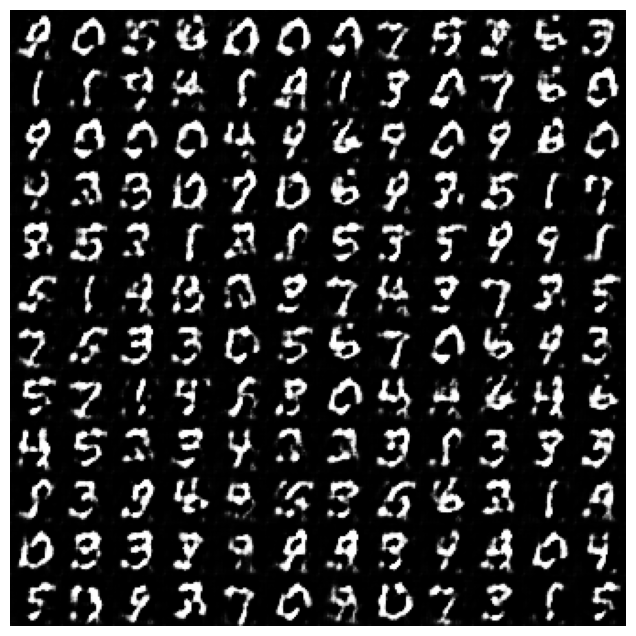

FD score: 73.25575
[ 2/10][200/600] Loss_D: 0.3115 Loss_G: 0.5871 D(x): 0.6154 D(G(z)): 0.3506


KeyboardInterrupt: 

In [198]:
if not skip_training:
    # YOUR CODE HERE
    optimizerG = torch.optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizerD = torch.optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
    #raise NotImplementedError()
    
    #optimizerD = ...
    #optimizerG = ...
    
    num_epochs = 10
    scores = []
    for epoch in range(num_epochs):
        for i, (real_images, real_cond) in enumerate(dataloader):
            real_images = real_images.to(device)
            real_cond = real_cond.to(device)
            batch_size = real_images.size(0)
            
            # YOUR CODE HERE
            optimizerD.zero_grad()
            z = torch.randn(100, nz, 1, 1, device=device)
            fake_cond = torch.randint(0, 10, (100,), device=device).type(torch.LongTensor)
            fake_images = netG(z, fake_cond)
            d_loss_real, D_real, d_loss_fake, D_fake = discriminator_loss(netD, real_images, real_cond, fake_images.detach(), fake_cond.detach())
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            optimizerD.step()
            
            
            
            #raise NotImplementedError()
            
            ###########################
            # Update the D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            
            # YOUR CODE HERE
            optimizerG.zero_grad()
            g_loss = generator_loss(netD, fake_images, fake_cond)
            g_loss.backward()
            optimizerG.step()
            #raise NotImplementedError()
            
            ###########################
            # Update G network: maximize log(D(G(z)))
            ###########################
            
            # Logging
            if (i+1) % 200 == 0:
                print('[%2d/%d][%3d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f'
                      % (epoch+1, num_epochs, i+1, len(dataloader),
                         d_loss.item(), g_loss.item(), D_real, D_fake))
                   
        with torch.no_grad():
            # Gennerate images
            z = torch.randn(1000, nz, 1, 1, device=device)
            c = torch.randint(0, 10, (1000,)).type(torch.LongTensor)
            samples = netG(z, c)
            
            # Plot generated images
            tools.plot_generated_samples(samples[:144])
            
            # Compute score
            score = fdscore.calculate(samples)
            scores.append(score.item())
            print(f'FD score: {score:.5f}')
    
    plt.plot(scores)

In [ ]:
# Save the model to disk (the pth-files will be submitted automatically together with your notebook)
# Set confirm=False if you do not want to be asked for confirmation before saving.
if not skip_training:
    tools.save_model(netG, '1_cgan_g.pth', confirm=True)
    tools.save_model(netD, '1_cgan_d.pth', confirm=True)

In [200]:
if skip_training:
    nz = 10
    netG = Generator(nz=nz, ngf=64, nc=1)
    netD = Discriminator(nc=1, ndf=64)

    tools.load_model(netG, '1_cgan_g.pth', device)
    tools.load_model(netD, '1_cgan_d.pth', device)

Model loaded from 1_cgan_g.pth.
Model loaded from 1_cgan_d.pth.


## cGAN evaluation

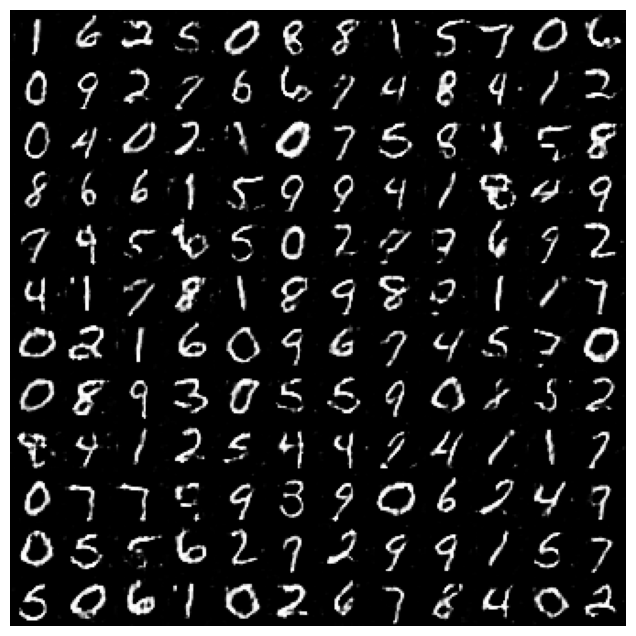

In [208]:
# Save generated samples (the pth-files will be submitted automatically together with your notebook)
if not skip_training:
    with torch.no_grad():
        z = torch.randn(144, nz, 1, 1, device=device)
        c = torch.randint(0, 10, (144,)).type(torch.LongTensor)
        samples = netG(z, c)
        torch.save(samples, '1_cgan_samples.pth')
else:
    samples = torch.load('1_cgan_samples.pth', map_location=lambda storage, loc: storage)

tools.plot_generated_samples(samples)

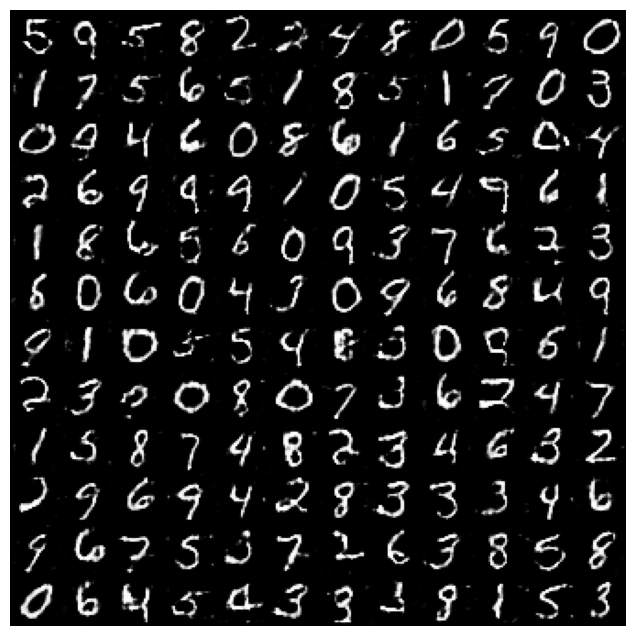

FD score: 42.42487


In [203]:
# Compute the FD score.
torch.manual_seed(0)
with torch.no_grad():
    z = torch.randn(1000, nz, 1, 1, device=device)
    c = torch.randint(0, 10, (1000,)).type(torch.LongTensor)
    samples = netG(z, c)
    tools.plot_generated_samples(samples[:144])
    score = fdscore.calculate(samples)

print(f'FD score: {score:.5f}')

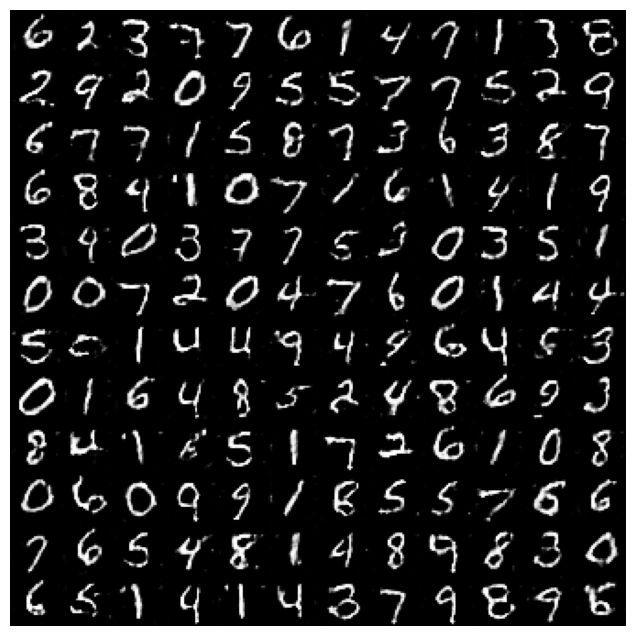

Accuracy of the classifications: 97.7 %


In [204]:
# This cell generates fake images and feeds them to a pretrained MNIST digit classifier and then computes the accuracy of the classifications.
# Your generator should generate such good images that the classifier labels them correctly with an accuracy >= 95%
torch.manual_seed(0)
classifier = fd.Classifier.pretrained()
classifier.to(device)
classifier.eval()
with torch.no_grad():
    z = torch.randn(1000, nz, 1, 1, device=device)
    c = torch.randint(0, 10, (1000,)).type(torch.LongTensor)
    fake_images = netG(z, c)
    tools.plot_generated_samples(fake_images[:144])
    
    outputs = classifier(fake_images)
    predicted_labels = torch.argmax(outputs, dim=1)
    
    # Calculate accuracy
    correct = (predicted_labels == c).sum().item()
    accuracy = correct / 1000 * 100

print(f"Accuracy of the classifications: {accuracy:.1f} %")

In [205]:
assert skip_training, "Set skip_training = True before submitting the assignment."

In [206]:
# This cell is used for grading

<div class="alert alert-block alert-info">
<b>Conclusion</b>
</div>

In this notebook, we learned how to train a conditional DCGAN model for generating images.